In [2]:
import os
import sys

import pandas as pd
import pandas_datareader.data as web
import numpy as np

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from arch import arch_model

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
p = print

p(sys.version)

# Machine: Linux x86_64

# 3.5.2 |Anaconda custom (64-bit)| (default, Jul  2 2016, 17:53:06) 
# [GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]

3.7.4 (default, Aug  9 2019, 18:34:13) [MSC v.1915 64 bit (AMD64)]


Let's use the pandas_datareader package to grab some sample data using the Yahoo Finance API.

In [4]:
end = '2015-01-01'
start = '2007-01-01'
get_px = lambda x: web.DataReader(x, 'yahoo', start=start, end=end)['Adj Close']

symbols = ['SPY','TLT','MSFT']

# raw adjusted close prices
data = pd.DataFrame({sym:get_px(sym) for sym in symbols})

# log returns
lrets = np.log(data/data.shift(1)).dropna()

# So what?  Why do we care about stationarity? 

A stationary time series (TS) is simple to predict as we can assume that future statistical properties are the same or proportional to current statistical properties.

Most of the models we use in TSA assume covariance-stationarity (#3 above). This means the descriptive statistics these models predict e.g. means, variances, and correlations, are only reliable if the TS is stationary and invalid otherwise.

"For example, if the series is consistently increasing over time, the sample mean and variance will grow with the size of the sample, and they will always underestimate the mean and variance in future periods. And if the mean and variance of a series are not well-defined, then neither are its correlations with other variables." - http://people.duke.edu/~rnau/411diff.htm

With that said, most TS we encounter in finance is NOT stationary. Therefore a large part of TSA involves identifying if the series we want to predict is stationary, and if it is not we must find ways to transform it such that it is stationary. (More on that later)

#Serial Correlation (Autocorrelation)
Essentially when we model a time series we decompose the series into three components: trend, seasonal/cyclical, and random. The random component is called the residual or error. It is simply the difference between our predicted value(s) and the observed value(s). Serial correlation is when the residuals (errors) of our TS models are correlated with each other. 

#Why Do We Care about Serial Correlation? 
We care about serial correlation because it is critical for the validity of our model predictions, and is intrinsically related to stationarity. Recall that the residuals (errors) of a stationary TS are serially uncorrelated by definition! If we fail to account for this in our models the standard errors of our coefficients are underestimated, inflating the size of our T-statistics. The result is too many Type-1 errors, where we reject our null hypothesis even when it is True! In layman's terms, ignoring autocorrelation means our model predictions will be bunk, and we're likely to draw incorrect conclusions about the impact of the independent variables in our model. 

#White Noise and Random Walks
White noise is the first Time Series Model (TSM) we need to understand. By definition a time series that is a white noise process has serially UNcorrelated errors and the expected mean of those errors is equal to zero. Another description for serially uncorrelated errors is, independent and identically distributed (i.i.d.). This is important because, if our TSM is appropriate and successful at capturing the underlying process, the residuals of our model will be i.i.d. and resemble a white noise process. Therefore part of TSA is literally trying to fit a model to the time series such that the residual series is indistinguishable from white noise.

Let's simulate a white noise process and view it. Below I introduce a convenience function for plotting the time series and analyzing the serial correlation visually. This code was adapted from the blog Seanabu.com

In [7]:
def tsplot(y, lags=None, figsize=(10, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return 



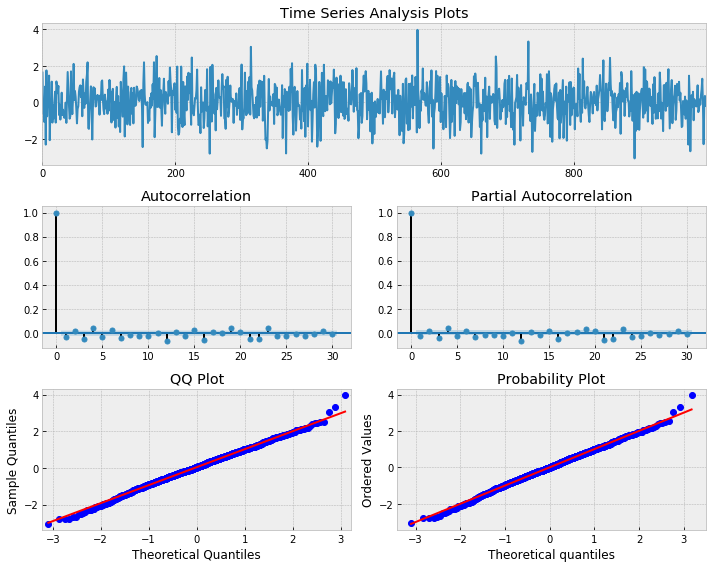

In [8]:
np.random.seed(1)

# plot of discrete white noise
randser = np.random.normal(size=1000)
tsplot(randser, lags=30)